In [1]:
'''Import packages'''
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms.time_evolvers.trotterization import TrotterQRTE
from qiskit.primitives import Estimator
from qiskit import Aer

import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### 1) Dynamic evolution a single spin-1/2 particle

'Create the initial state |0>'

'Define the hamiltonian'

'Define the observable and the estimator'

'Define the evolution problem'

'Evolve the system'

'Get the observable values'

'Visualize the time evolution of the observable'

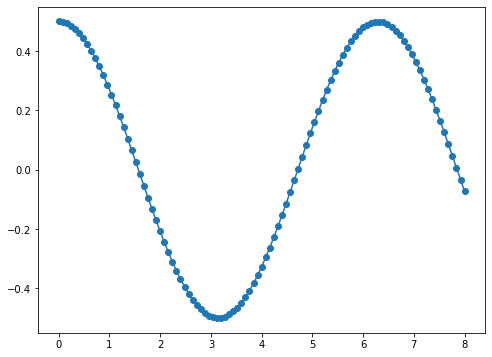

In [47]:
'''Create the initial state |0>'''
qreg = QuantumRegister(size = 1)
qcir = QuantumCircuit(qreg)

'''Define the hamiltonian'''
omega = 0.5
hamiltonian = SparsePauliOp(data = "X", coeffs = -omega)

'''Define the observable and the estimator'''
obs = SparsePauliOp(data = "Z", coeffs = 0.5)
estimator = Estimator()

'''Define the evolution problem'''
time = 8.0
initial_state = qcir
problem = TimeEvolutionProblem(hamiltonian,time,initial_state,aux_operators=[obs])

'''Evolve the system'''
num_timesteps = 100
evolution = TrotterQRTE(estimator=estimator, num_timesteps=num_timesteps).evolve(problem)

'''Get the observable values'''
obs_values = np.array(evolution.observables)[:,:,0][:,0]

'''Visualize the time evolution of the observable'''
x_times = np.linspace(0,time,num=num_timesteps+1)
fig = plt.figure(figsize=(8,6))
plt.plot(x_times,obs_values,'o-')

### 2) Dynamic evolution a single spin-1/2 particle with spontaneous collapse

In [62]:
#initial_state, hamiltonian, observable and estimator are the same of the prevoius problem
'''Define some variables'''
initial_state = QuantumCircuit(1)
time = 50
num_timesteps = 300
lam = 2

'''Define the collapse times'''
def _collapse_times(time, lam):
    t_run = 0
    collapse_array = []
    while t_run <= time:
        t = np.random.poisson(lam,size=1)
        if t == 0:
            continue
        t_run += t
        if t_run <= time:
            collapse_array.append(t)
    
    return np.array(collapse_array)[:,0]

collapse_times = _collapse_times(time,lam)
collapse_timesteps = collapse_times*int(num_timesteps/time)
print("collapse_times:", collapse_times)
print("collapse_timesteps:", collapse_timesteps)

x_collapses = []
for i in range(len(collapse_times)):
    if i == 0:
        x_collapses.append(collapse_times[0])
    else:
        x_collapses.append(x_collapses[-1] + collapse_times[i])
print("x_collapses:", x_collapses)



'''Define the dynamic'''

def QRTE_evolution(hamiltonian, t_col, initial_state, n_timesteps, obs):
    problem = TimeEvolutionProblem(hamiltonian, t_col, initial_state, aux_operators = [obs])
    evolution = TrotterQRTE(estimator = estimator, num_timesteps = n_timesteps).evolve(problem)
    obs_values = np.array(evolution.observables)[:,:,0][:,0]

    return evolution, obs_values

def dynamic(hamiltonian, initial_state, t_col, n_timesteps, obs):
    evolution, obs_values = QRTE_evolution(hamiltonian, t_col, initial_state, n_timesteps, obs)
    state_pre = evolution.evolved_state

    #Get the state before the collapse as a vector
    backend = Aer.get_backend("statevector_simulator")
    state = execute(state_pre, backend).result().get_statevector(state_pre)

    #Collapse
    x = np.random.uniform(0,1)
    if x <= np.abs(state[0])**2:
        return 0, obs_values
    else:
        return 1, obs_values

    
def experiment(hamiltonian, initial_state, time, num_timesteps, collapse_times, collapse_timesteps, obs):
    counter_0 = 0
    counter_1 = 0

    all_obs_values = []
    collapse_values = []

    for i in range(len(collapse_times)):
        spin_state, obs_values = dynamic(hamiltonian, initial_state, collapse_times[i], collapse_timesteps[i], obs)
        if spin_state == 0:
            counter_0 += 1
            initial_state = QuantumCircuit(1)
            collapse_values.append(0.5)
        else:
            counter_1 += 1
            initial_state = QuantumCircuit(1)
            initial_state.x(0)
            initial_state = initial_state
            collapse_values.append(-0.5)

        for j in range(len(obs_values)):
            all_obs_values.append(obs_values[j])
        
    if np.sum(collapse_times) != time:
        time_fin = time - np.sum(collapse_times)
        timesteps_fin = num_timesteps - np.sum(collapse_timesteps)
        evolution_trash, obs_values = QRTE_evolution(hamiltonian, time_fin, initial_state, timesteps_fin, obs)
        for j in range(len(obs_values)):
            all_obs_values.append(obs_values[j])
    
    return all_obs_values, counter_0, counter_1, collapse_values


def visualization(all_obs_values, time, num_timesteps, collapse_values):
    x_times = np.linspace(0,time,num=num_timesteps+len(collapse_times)+1)
    fig = plt.figure(figsize=(12,6))
    plt.plot(x_times,all_obs_values,'-', alpha = 0.5)
    plt.plot(x_collapses, collapse_values, 'o', c = 'r')


'Define some variables'

'Define the collapse times'

collapse_times: [2 5 1 1 3 3 1 5 2 1 2 4 4 3 2 2 1 2 1 2 2]
collapse_timesteps: [12 30  6  6 18 18  6 30 12  6 12 24 24 18 12 12  6 12  6 12 12]
x_collapses: [2, 7, 8, 9, 12, 15, 16, 21, 23, 24, 26, 30, 34, 37, 39, 41, 42, 44, 45, 47, 49]


'Define the dynamic'

In [63]:
y, counter_0, counter_1, collapse_values = experiment(hamiltonian, initial_state, time, num_timesteps, collapse_times, collapse_timesteps, obs)

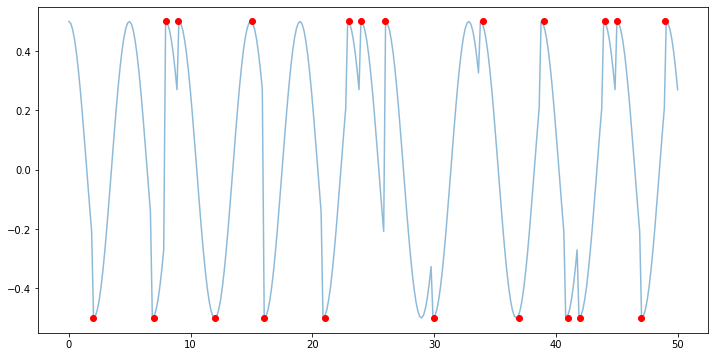

In [64]:
visualization(y, time, num_timesteps, collapse_values)

In [65]:
counter_0
counter_1

11

10